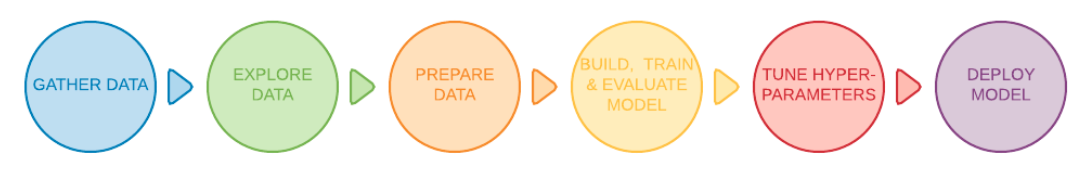

# Dev day 24 November 2023 - Workshop ML

install some dependencies

In [1]:
%%capture
!pip install fasttext
!pip install scattertext
!pip install matplotlib

# Gather data:
##Import the file and read it into a dataframe

In [2]:
from google.colab import files

uploaded = files.upload()
# upload workshop file here

Saving workshop_set.csv to workshop_set.csv


In [5]:
from google.colab import drive
# drive.mount('/content/drive')

Use pandas for data reading and take aquick look:

In [6]:
import pandas as pd

df = pd.read_csv('workshop_set.csv')

We have our first 'data frame':

In [7]:
display(df.head(5))
display(df.describe())

,Yelp URL,Rating,Date,Review Text
0,https://www.yelp.com/biz/sprinkles-las-vegas-l...,4,9/28/2018,Great customer service! The staff was knowledg...
1,https://www.yelp.com/biz/matcha-cafe-maiko-cha...,4,12/6/2019,I'm so glad they came to Charlotte! I've been ...
2,https://www.yelp.com/biz/rewind-ice-cream-boba...,5,9/7/2020,Manager reached out letting me know that the i...
3,https://www.yelp.com/biz/am%C3%A9lies-french-b...,5,9/14/2019,We were in town for a Wedding. The bride and g...
4,https://www.yelp.com/biz/donut-bar-las-vegas,3,4/3/2018,I don't understand the hype. They taste medioc...


,Rating
count,17906.000000
mean,4.132749
std,1.201913
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


# Explore Data

Inspect distribution of labels, equal is better

In [8]:
def print_count_per_ranking(df: pd.DataFrame):
    df['Rating']\
    .value_counts()\
    .plot(kind='bar',figsize=(6,6))

In [9]:
def even_distribute_hard(df_param: pd.DataFrame) -> pd.DataFrame:
    #even distribute rankings, to minimum count of labels:

    lowest_count = df['Rating'].value_counts().min()
    return df_param.groupby('Rating', group_keys=False).apply(lambda x: x.sample(lowest_count))

def even_distribute_soft(df_param: pd.DataFrame) -> pd.DataFrame:
    #or reduce ranking 5 to even out to remove 6000 items. Still not very equal but less data is taken out of the training set.

    df_subset = df_param.loc[df_param['Rating']==5].sample(n=6000)
    return df_param[~df_param.index.isin(df_subset.index)]

Inspect spread of words per review

In [10]:
def print_spread_of_text_length(df: pd.DataFrame):
    df['words'] = df['Review Text']\
            .str.strip()\
            .str.split(' ')
    df['word_length'] = df['words'].apply(lambda l: len(l))
    df['word_length'].hist(bins=1000)

Popular words for a label

In [11]:
def list_words_for_label(df_param: pd.DataFrame, ranking:int=1, label:str='Review Text') -> pd.Series:
    df_param['words'] = df_param[label]\
                .str.strip()\
                .str.split(' ')

    return df_param\
            .loc[df['Rating']==ranking]\
            .explode('words')\
            .groupby('Rating')['words']\
            .value_counts()\
            .loc[lambda x: x>4]

Execute one of the above functions

Rating  words
4       the      17335
        and      12678
        a        11532
        I        11103
        to        8782
        was       6742
        of        6590
        is        5185
        in        4508
        it        4062
        for       4048
        The       3970
        but       3613
        with      3110
        ice       2906
        that      2889
        you       2556
        cream     2447
        on        2426
        have      2332
Name: words, dtype: int64

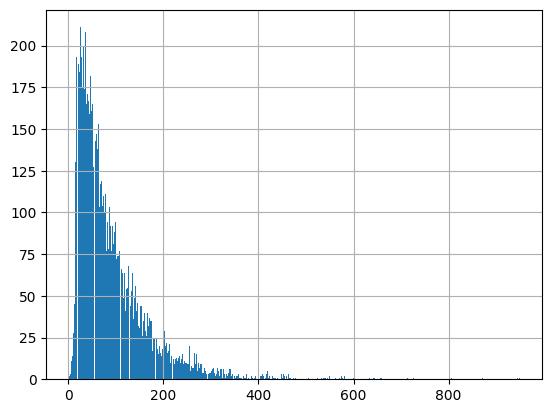

In [12]:
# print_count_per_ranking(df)

# df_even = even_distribute_soft(df)
# print_count_per_ranking(df_even)

# df = even_distribute_hard(df)
# print_count_per_ranking(df)


print_spread_of_text_length(df)

# print popular words
list_words_for_label(df, ranking=4,).head(20)


## **Visualize the data**

In [13]:
# import scattertext
# import spacy
# nlp = spacy.load('en_core_web_sm')

# corpus = (scattertext.CorpusFromPandas(df,
#                                            category_col='Rating',
#                                            text_col='Review Text',
#                                            nlp=nlp)
#               .build()
#               .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
#               )
# html = scattertext.produce_scattertext_explorer(
#                    corpus,
#                    category='1',
#                    category_name='Low Rating',
#                    not_category_name='High Rating',
#                    width_in_pixels=1000,
#                    metadata=df['Rating'])
# from IPython.display import IFrame

# file_name = 'scattertextdemo_plot.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# files.download(file_name)

# Prepare Data

## **Cleaning**
1. case based cleaning
2. remove punctuation
3. remove stop words (words that add nothing)
4. remove unimportant common words
5. inspect good and bad and remove more words

Use panda dataframes to manipulate and create new 'cleaned' columns of the 'Review Text' column. Do one cleaning step at a time to create a new column, then use the latest column for your next cleaning step.

**Useful examples:**

To replace one item for another in an entire column and put the result into a new column:

```
df["newColumn"] = df["textColumn"].str.replace('','')
```

To perform a function on every row in an entire column, e.g. remove all the words in a list:

```
df['newColumn'] = df['textColumn'].apply(lambda row: " ".join(word for word in row.split() if word not in stopwords))
```

To make every word lowercase:
```
df["newColumn"] = df["textColumn"].str.lower()
```

At the end you should have added multiple columns to the dataframe.

###1. case based cleaning.
make each word in the text lower case.

In [14]:
## create a new column called 'lowercase'

df["lowercase"] = df["Review Text"].str.lower()


# visualize new rows:
df.loc[:,['lowercase', 'Review Text']].head()

,lowercase,Review Text
0,great customer service! the staff was knowledg...,Great customer service! The staff was knowledg...
1,i'm so glad they came to charlotte! i've been ...,I'm so glad they came to Charlotte! I've been ...
2,manager reached out letting me know that the i...,Manager reached out letting me know that the i...
3,we were in town for a wedding. the bride and g...,We were in town for a Wedding. The bride and g...
4,i don't understand the hype. they taste medioc...,I don't understand the hype. They taste medioc...


###2. punctuation and regular expression
 can remove unwanted elements such as punctuation using a regular expression.

 handy regular expressions:
 - for punctation [^\w\s]
 - for numbers (\d+)
 - for double spaces (/\s\s+/g)
 - others...

In [15]:
df["punctuation"] = df["lowercase"].str.replace('[^\w\s]','')

# visualize
df.loc[:,['punctuation', 'lowercase', 'Review Text']].head()

<ipython-input-15-e5a84ac18cc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["punctuation"] = df["lowercase"].str.replace('[^\w\s]','')


,punctuation,lowercase,Review Text
0,great customer service the staff was knowledge...,great customer service! the staff was knowledg...,Great customer service! The staff was knowledg...
1,im so glad they came to charlotte ive been to ...,i'm so glad they came to charlotte! i've been ...,I'm so glad they came to Charlotte! I've been ...
2,manager reached out letting me know that the i...,manager reached out letting me know that the i...,Manager reached out letting me know that the i...
3,we were in town for a wedding the bride and gr...,we were in town for a wedding. the bride and g...,We were in town for a Wedding. The bride and g...
4,i dont understand the hype they taste mediocre...,i don't understand the hype. they taste medioc...,I don't understand the hype. They taste medioc...


###3. removing stop words
stop words are words that add no significant meaning. Can do this using available dataset, e.g. nltk.

In [16]:
## 3
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = stopwords.words('english')
display(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
# remove stopwords
df['stopwords'] = df['punctuation'].apply(lambda x: " ".join(word for word in x.split() if word not in stopwords))

# visualize
df.loc[:,['stopwords','punctuation', 'lowercase', 'Review Text']].head()

,stopwords,punctuation,lowercase,Review Text
0,great customer service staff knowledgeable ope...,great customer service the staff was knowledge...,great customer service! the staff was knowledg...,Great customer service! The staff was knowledg...
1,im glad came charlotte ive one dmv area menu i...,im so glad they came to charlotte ive been to ...,i'm so glad they came to charlotte! i've been ...,I'm so glad they came to Charlotte! I've been ...
2,manager reached letting know issue resolved wo...,manager reached out letting me know that the i...,manager reached out letting me know that the i...,Manager reached out letting me know that the i...
3,town wedding bride groom arranged progressive ...,we were in town for a wedding the bride and gr...,we were in town for a wedding. the bride and g...,We were in town for a Wedding. The bride and g...
4,dont understand hype taste mediocre best super...,i dont understand the hype they taste mediocre...,i don't understand the hype. they taste medioc...,I don't understand the hype. They taste medioc...


###4. removing words that are common but not valuable through inspection

inspect the whole dataset for which words are used most, can also inspect common words for each rating.

Then create your own stop word list

In [18]:
## 4
pd.Series(" ".join(df['stopwords']).split()).value_counts()[:50]


cream         15653
ice           14380
place          8451
good           7596
like           6289
one            5834
get            5409
great          5131
chocolate      5092
flavors        4741
try            4569
time           4488
got            4352
back           4300
go             4300
cake           4122
love           4073
delicious      4047
also           3929
really         3906
sweet          3896
would          3751
best           3709
little         3199
line           3150
im             3113
ive            3007
flavor         2920
dont           2920
amazing        2889
coffee         2843
definitely     2797
donuts         2737
cookie         2731
service        2687
bakery         2581
donut          2565
milk           2543
even           2483
always         2465
well           2314
worth          2292
tried          2237
didnt          2231
staff          2215
friendly       2211
nice           2172
taste          2141
first          2094
cookies        2074


In [19]:
## create own stop word list
other_stop_words = [ "also", "would", "got", "first", "one", "cream", "ice"]
df['cleaned'] = df['stopwords'].apply(lambda x: " ".join(word for word in x.split() if word not in other_stop_words))

# visualize
df.loc[:,['cleaned', 'stopwords','punctuation', 'lowercase', 'Review Text']].head()

,cleaned,stopwords,punctuation,lowercase,Review Text
0,great customer service staff knowledgeable ope...,great customer service staff knowledgeable ope...,great customer service the staff was knowledge...,great customer service! the staff was knowledg...,Great customer service! The staff was knowledg...
1,im glad came charlotte ive dmv area menu isnt ...,im glad came charlotte ive one dmv area menu i...,im so glad they came to charlotte ive been to ...,i'm so glad they came to charlotte! i've been ...,I'm so glad they came to Charlotte! I've been ...
2,manager reached letting know issue resolved ha...,manager reached letting know issue resolved wo...,manager reached out letting me know that the i...,manager reached out letting me know that the i...,Manager reached out letting me know that the i...
3,town wedding bride groom arranged progressive ...,town wedding bride groom arranged progressive ...,we were in town for a wedding the bride and gr...,we were in town for a wedding. the bride and g...,We were in town for a Wedding. The bride and g...
4,dont understand hype taste mediocre best super...,dont understand hype taste mediocre best super...,i dont understand the hype they taste mediocre...,i don't understand the hype. they taste medioc...,I don't understand the hype. They taste medioc...


inspect only certain ratings:

In [20]:
## 5
# only ratings with value 1
bad_df = df.apply(lambda row: row['cleaned'] if row['Rating']==1 else "", axis=1)
bad_series = pd.Series(" ".join(bad_df).split()).value_counts()[:25]
display(bad_series)

# only ratings with value 5
good_df = df.apply(lambda row: row['cleaned'] if row['Rating']==5 else "", axis=1)
good_series = pd.Series(" ".join(good_df).split()).value_counts()[:25]
display(good_series)



cake       522
like       494
place      432
get        353
back       339
time       338
good       311
go         280
order      276
service    269
dont       265
even       247
didnt      244
line       238
bakery     236
asked      220
said       220
us         217
ordered    209
never      204
people     201
went       199
better     198
try        194
could      190
dtype: int64

place         4682
good          3279
great         3025
flavors       2920
love          2737
delicious     2724
best          2666
get           2588
like          2522
chocolate     2453
go            2304
try           2302
back          2253
amazing       2209
time          2172
sweet         1905
ive           1760
really        1653
definitely    1620
always        1586
donuts        1534
donut         1504
cake          1497
little        1493
friendly      1490
dtype: int64

Cleaning and removing stopwords general function

In [21]:
from spacy.lang.en.stop_words import STOP_WORDS

stopwords = STOP_WORDS.copy()
other_stop_words = [ "also", "would", "got", "first", "one", "cream", "ice"]


def cleanup(df_param: pd.DataFrame) -> pd.DataFrame:
    df_param['text_clean'] = df_param['Review Text'].str.lower()
    df_param['text_clean'] = df_param['text_clean'].str.strip()
    df_param['text_clean'] = df_param['text_clean'].str.replace('[^\w\s]',' ',regex=True)
    df_param['text_clean'] = df_param['text_clean'].apply(lambda x: " ".join(word for word in x.split(' ') if word not in stopwords))
    df_param['text_clean'] = df_param['text_clean'].apply(lambda x: " ".join(word for word in x.split(' ') if word not in other_stop_words))
    df_param['text_clean'] = df_param['text_clean'].apply(lambda x: " ".join(word for word in x.split(' ') if len(word)>1))

    return df_param;

df_cleaned = cleanup(df)

# print popular words, cleaned
list_words_for_label(df_cleaned, label='text_clean',ranking=5).head(20)

Rating  words     
5       place         4702
        good          3299
        great         3037
        flavors       2936
        love          2746
        delicious     2744
        best          2682
        like          2562
        chocolate     2516
        try           2321
        amazing       2220
        time          2203
        ve            2070
        sweet         1942
        definitely    1624
        donuts        1543
        donut         1522
        cake          1519
        friendly      1508
        little        1497
Name: words, dtype: int64

In [22]:
df_cleaned['text_clean'].head(15)


0     great customer service staff knowledgeable ope...
1     glad came charlotte ve dmv area menu isn exten...
2     manager reached letting know issue resolved ha...
3     town wedding bride groom arranged progressive ...
4     don understand hype taste mediocre best super ...
5     staff friendly knowledgeable helpful flavored ...
6     amazing fantastic worth drive tastes fresh fla...
7     pure americana right best soft serve pittsburg...
8     crepe super freak like taste let start usually...
9     need hit place try zanzibar chocolate neeeeeed...
10    amazing place satisfy sweet tooth tucked away ...
11    fantastic pastries drinks phenomenal atmospher...
12    rating tldr youre looking halo halo come don s...
13    went dinner decided drive try little gem disco...
14    mmmm good way graeter wi ship end spending for...
Name: text_clean, dtype: object

# Build, Train and Evaluate model

## **apply model**
1. put data in right format
2. train

Fasttext requires the data to be in a specific format.
Each row should contain the following on a single line.
`__labelName__ textData`

Furthermore, we want to reduce the number of labels. Rather than a 5-point scale, we would like to divide them into *negative*, *neutral* and *positive* reviews.

Below we write a function that Code below puts it in that format.

In [23]:
## put data in right format for fasttext
def map_adjusted_rating(rating):
    if rating in [1, 2]:
        return '__label__negative'
    elif rating == 3:
        return '__label__neutral'
    elif rating in [4, 5]:
        return '__label__positive'

# adjust data
df_cleaned['adjusted_rating'] = df_cleaned['Rating'].apply(lambda x:(map_adjusted_rating(x)))
df_cleaned['fasttext_data'] = df_cleaned['adjusted_rating'] + ' ' + df_cleaned['text_clean']
display(df_cleaned.head(15))

,Yelp URL,Rating,Date,Review Text,words,word_length,lowercase,punctuation,stopwords,cleaned,text_clean,adjusted_rating,fasttext_data
0,https://www.yelp.com/biz/sprinkles-las-vegas-l...,4,9/28/2018,Great customer service! The staff was knowledg...,"[great, customer, service, staff, knowledgeabl...",35,great customer service! the staff was knowledg...,great customer service the staff was knowledge...,great customer service staff knowledgeable ope...,great customer service staff knowledgeable ope...,great customer service staff knowledgeable ope...,__label__positive,__label__positive great customer service staff...
1,https://www.yelp.com/biz/matcha-cafe-maiko-cha...,4,12/6/2019,I'm so glad they came to Charlotte! I've been ...,"[glad, came, charlotte, ve, dmv, area, menu, i...",120,i'm so glad they came to charlotte! i've been ...,im so glad they came to charlotte ive been to ...,im glad came charlotte ive one dmv area menu i...,im glad came charlotte ive dmv area menu isnt ...,glad came charlotte ve dmv area menu isn exten...,__label__positive,__label__positive glad came charlotte ve dmv a...
2,https://www.yelp.com/biz/rewind-ice-cream-boba...,5,9/7/2020,Manager reached out letting me know that the i...,"[manager, reached, letting, know, issue, resol...",32,manager reached out letting me know that the i...,manager reached out letting me know that the i...,manager reached letting know issue resolved wo...,manager reached letting know issue resolved ha...,manager reached letting know issue resolved ha...,__label__positive,__label__positive manager reached letting know...
3,https://www.yelp.com/biz/am%C3%A9lies-french-b...,5,9/14/2019,We were in town for a Wedding. The bride and g...,"[town, wedding, bride, groom, arranged, progre...",157,we were in town for a wedding. the bride and g...,we were in town for a wedding the bride and gr...,town wedding bride groom arranged progressive ...,town wedding bride groom arranged progressive ...,town wedding bride groom arranged progressive ...,__label__positive,__label__positive town wedding bride groom arr...
4,https://www.yelp.com/biz/donut-bar-las-vegas,3,4/3/2018,I don't understand the hype. They taste medioc...,"[don, understand, hype, taste, mediocre, best,...",143,i don't understand the hype. they taste medioc...,i dont understand the hype they taste mediocre...,dont understand hype taste mediocre best super...,dont understand hype taste mediocre best super...,don understand hype taste mediocre best super ...,__label__neutral,__label__neutral don understand hype taste med...
5,https://www.yelp.com/biz/sloans-grand-canal-sh...,5,5/27/2019,"Staff is very friendly, knowledgeable, and hel...","[staff, friendly, knowledgeable, helpful, flav...",28,"staff is very friendly, knowledgeable, and hel...",staff is very friendly knowledgeable and helpf...,staff friendly knowledgeable helpful three fla...,staff friendly knowledgeable helpful three fla...,staff friendly knowledgeable helpful flavored ...,__label__positive,__label__positive staff friendly knowledgeable...
6,https://www.yelp.com/biz/sweet-republic-scotts...,5,5/29/2010,Amazing. Fantastic. Worth the drive - everythi...,"[amazing, fantastic, worth, drive, tastes, fre...",32,amazing. fantastic. worth the drive - everythi...,amazing fantastic worth the drive everything ...,amazing fantastic worth drive everything taste...,amazing fantastic worth drive everything taste...,amazing fantastic worth drive tastes fresh fla...,__label__positive,__label__positive amazing fantastic worth driv...
7,https://www.yelp.com/biz/pages-pittsburgh,5,8/29/2019,Pure Americana right here! Some of the best so...,"[pure, americana, right, best, soft, serve, pi...",102,pure americana right here! some of the best so...,pure americana right here some of the best sof...,pure americana right best soft serve ice cream...,pure americana right best soft serve pittsburg...,pure americana right best soft serve pittsburg...,__label__positive,__label__positive pure america

Let's also write a function that takes a data frame and writes the prepared data column to a line-separated text file.

In [24]:
def write_to_fasttext_file(data_frame, column_name, file_name: str) -> None:
    with open(file_name,'w') as fout:
        for index, row in data_frame.iterrows():
            fout.write(row[column_name]+"\n")

## **Split data into train, test, validation**

In [25]:
from sklearn.model_selection import train_test_split

train_df, test_and_val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_and_val_df, test_size=0.5, random_state=42)


In [26]:
display(train_df.head())
display(test_df.head())
display(val_df.head())

,Yelp URL,Rating,Date,Review Text,words,word_length,lowercase,punctuation,stopwords,cleaned,text_clean,adjusted_rating,fasttext_data
8457,https://www.yelp.com/biz/am%C3%A9lies-french-b...,2,8/2/2019,Overall extremely disappointed. We ordered a s...,"[overall, extremely, disappointed, ordered, sa...",140,overall extremely disappointed. we ordered a s...,overall extremely disappointed we ordered a sa...,overall extremely disappointed ordered salted ...,overall extremely disappointed ordered salted ...,overall extremely disappointed ordered salted ...,__label__negative,__label__negative overall extremely disappoint...
11282,https://www.yelp.com/biz/sprinkles-las-vegas-l...,4,6/21/2015,The cupcakes are amazing! I always stop to bri...,"[cupcakes, amazing, stop, bring, home, service...",78,the cupcakes are amazing! i always stop to bri...,the cupcakes are amazing i always stop to brin...,cupcakes amazing always stop bring home servic...,cupcakes amazing always stop bring home servic...,cupcakes amazing stop bring home service decen...,__label__positive,__label__positive cupcakes amazing stop bring ...
9332,https://www.yelp.com/biz/mitchells-homemade-ic...,5,2/8/2015,Love love love homemade ice cream! This place ...,"[love, love, love, homemade, place, remind, lo...",94,love love love homemade ice cream! this place ...,love love love homemade ice cream this place r...,love love love homemade ice cream place really...,love love love homemade place really remind lo...,love love love homemade place remind local hom...,__label__positive,__label__positive love love love homemade plac...
1801,https://www.yelp.com/biz/sprinkles-las-vegas-l...,5,4/26/2018,The best damn cupcakes I've ever had in my lif...,"[best, damn, cupcakes, ve, life, moist, heavy,...",30,the best damn cupcakes i've ever had in my lif...,the best damn cupcakes ive ever had in my life...,best damn cupcakes ive ever life moist heavy b...,best damn cupcakes ive ever life moist heavy b...,best damn cupcakes ve life moist heavy belgian...,__label__positive,__label__positive best damn cupcakes ve life m...
4756,https://www.yelp.com/biz/donut-bar-las-vegas,5,7/8/2017,Place was AMAZING!!! The variety of donuts the...,"[place, amazing, variety, donuts, tasty, place...",27,place was amazing!!! the variety of donuts the...,place was amazing the variety of donuts they h...,place amazing variety donuts tasty place attra...,place amazing variety donuts tasty place attra...,place amazing variety donuts tasty place attra...,__label__positive,__label__positive place amazing variety donuts...


,Yelp URL,Rating,Date,Review Text,words,word_length,lowercase,punctuation,stopwords,cleaned,text_clean,adjusted_rating,fasttext_data
1254,https://www.yelp.com/biz/sloans-grand-canal-sh...,2,1/26/2019,The ice cream actually tasted very good. But t...,"[actually, tasted, good, scoops, minuscule, ti...",58,the ice cream actually tasted very good. but t...,the ice cream actually tasted very good but th...,ice cream actually tasted good scoops minuscul...,actually tasted good scoops minuscule tiny pai...,actually tasted good scoops minuscule tiny pai...,__label__negative,__label__negative actually tasted good scoops ...
4977,https://www.yelp.com/biz/milk-bar-las-vegas-la...,2,3/26/2018,I think the place is super cute. The employees...,"[think, place, super, cute, employees, working...",146,i think the place is super cute. the employees...,i think the place is super cute the employees ...,think place super cute employees working count...,think place super cute employees working count...,think place super cute employees working count...,__label__negative,__label__negative think place super cute emplo...
13010,https://www.yelp.com/biz/batch-bakehouse-madison,5,8/11/2017,"This is a serious bakery. Fantastic selection,...","[bakery, fantastic, selection, great, service,...",33,"this is a serious bakery. fantastic selection,...",this is a serious bakery fantastic selection g...,serious bakery fantastic selection great servi...,serious bakery fantastic selection great servi...,bakery fantastic selection great service delic...,__label__positive,__label__positive bakery fantastic selection g...
10499,https://www.yelp.com/biz/scooptopia-phoenix,5,12/31/2019,"I have found my go-to place for sweets, specif...","[found, place, sweets, specifically, halo, hal...",101,"i have found my go-to place for sweets, specif...",i have found my goto place for sweets specific...,found goto place sweets specifically halo halo...,found goto place sweets specifically halo halo...,found place sweets specifically halo halo good...,__label__positive,__label__positive found place sweets specifica...
2298,https://www.yelp.com/biz/sprinkles-las-vegas-l...,4,5/28/2015,There's a cupcake ATM attached to this bakery ...,"[cupcake, atm, attached, bakery, satisfies, la...",58,there's a cupcake atm attached to this bakery ...,theres a cupcake atm attached to this bakery t...,theres cupcake atm attached bakery satisfies l...,theres cupcake atm attached bakery satisfies l...,cupcake atm attached bakery satisfies late nig...,__label__positive,__label__positive cupcake atm attached bakery ...


,Yelp URL,Rating,Date,Review Text,words,word_length,lowercase,punctuation,stopwords,cleaned,text_clean,adjusted_rating,fasttext_data
13650,https://www.yelp.com/biz/donut-bar-las-vegas,4,11/1/2017,Was in the area for a jury summons and decided...,"[area, jury, summons, decided, place, try, coo...",119,was in the area for a jury summons and decided...,was in the area for a jury summons and decided...,area jury summons decided give place try cool ...,area jury summons decided give place try cool ...,area jury summons decided place try cool littl...,__label__positive,__label__positive area jury summons decided pl...
479,https://www.yelp.com/biz/milk-bar-las-vegas-la...,5,10/20/2017,I just wanna say thank you Milk Bar and Christ...,"[wanna, thank, milk, bar, christina, tosi, ope...",64,i just wanna say thank you milk bar and christ...,i just wanna say thank you milk bar and christ...,wanna say thank milk bar christina tosi openin...,wanna say thank milk bar christina tosi openin...,wanna thank milk bar christina tosi opening lo...,__label__positive,__label__positive wanna thank milk bar christi...
1516,https://www.yelp.com/biz/sweet-republic-scotts...,5,4/4/2015,"A little pricey, but the quality is there as w...","[little, pricey, quality, sure, try, mint, fla...",25,"a little pricey, but the quality is there as w...",a little pricey but the quality is there as we...,little pricey quality well make sure try mint ...,little pricey quality well make sure try mint ...,little pricey quality sure try mint flavor new,__label__positive,__label__positive little pricey quality sure t...
14104,https://www.yelp.com/biz/am%C3%A9lies-french-b...,4,10/12/2020,"Friendly staff, tasty pastries, and decent cof...","[friendly, staff, tasty, pastries, decent, cof...",38,"friendly staff, tasty pastries, and decent cof...",friendly staff tasty pastries and decent coffe...,friendly staff tasty pastries decent coffee th...,friendly staff tasty pastries decent coffee th...,friendly staff tasty pastries decent coffee th...,__label__positive,__label__positive friendly staff tasty pastrie...
16709,https://www.yelp.com/biz/donut-bar-las-vegas,5,12/8/2019,This is such a cool and unique donut place. We...,"[cool, unique, donut, place, stopped, saturday...",99,this is such a cool and unique donut place. we...,this is such a cool and unique donut place we ...,cool unique donut place stopped saturday morni...,cool unique donut place stopped saturday morni...,cool unique donut place stopped saturday morni...,__label__positive,__label__positive cool unique donut place stop...


In [27]:
write_to_fasttext_file(train_df, "fasttext_data", "data.train")
write_to_fasttext_file(test_df, "fasttext_data", "data.test")
write_to_fasttext_file(val_df, "fasttext_data", "data.valid")

In [28]:
!head data.train

__label__negative overall extremely disappointed ordered salted caramel brownie seeing amazing reviews pleased brownie tasted cooked raw time bitter salt couldn cut plastic utensils daughter order strawberry cheese pastry pretty good prices little high water station warm water fan decorations cup tea fit overall theme cafe thing stood awkwardly placed painting strange little girl bathroom returning recommending plenty coffee places near way better recommend checking smelly cat coffee bar
__label__positive cupcakes amazing stop bring home service decent overly friendly cookies disappointing better ones home ok stick cupcakes wrong favorites peanut butter chip chocolate peanut butter like snores salted carmel month special longer sell
__label__positive love love love homemade place remind local home exception production floor counter place order cool fresh flavorful sure absolutely love creamy tasty texture melt mouth mitchells offers sure support local homemade places isn like fan ll su

**Train with default parameters**:

In [29]:
import fasttext
model_classification = fasttext.train_supervised(input='data.train')


**Test the trained model and print the statistics**

In [30]:
def print_results(model_output):
    num_records, precision, recall = model_output
    f1 = 2 * (precision * recall) / (precision + recall)

    print("records\t{}".format(num_records))
    print("Precision\t{:.3f}".format(precision))
    print("Recall\t{:.3f}".format(recall))
    print("F1\t{:.3f}".format(f1))
    print()

In [31]:
result = model_classification.test("data.test")
print_results(result)

records	2686
Precision	0.854
Recall	0.854
F1	0.854



Predict some custom reviews using .predict

In [32]:
model_classification.predict("The food was bad")

(('__label__negative',), array([0.93359494]))

# Training hyperparameters

**Let's try changing some parameters and training again**


In [33]:
model_2grams = fasttext.train_supervised(input="data.train", wordNgrams=2)

Has performance on the test set improved?



In [34]:
result = model_2grams.test("data.test")
print_results(result)

records	2686
Precision	0.850
Recall	0.850
F1	0.850



Try it yourself -- play around with some of the parameters for the train_supervised method:
https://fasttext.cc/docs/en/python-module.html#train_supervised-parameters

What about the validation set we created earlier? We can use it to autotune the hyperparameters.

In [35]:
model_autotuned = fasttext.train_supervised(input="data.train",autotuneValidationFile="data.valid")

In [36]:
result = model_autotuned.test("data.test")
print_results(result)

records	2686
Precision	0.859
Recall	0.859
F1	0.859

